# Preamble for Python

In [1]:
from sympy import *
init_printing(use_latex='mathjax')

# Plotting
%matplotlib inline
## Make inline plots raster graphics
from IPython.display import set_matplotlib_formats
## Import modules for plotting and data analysis
import matplotlib.pyplot as plt
from matplotlib import gridspec,rc,colors
import matplotlib.ticker as plticker
## Parameters for seaborn plots
import seaborn as sns
sns.set(style='white',font_scale=1.5,rc={"xtick.major.size": 6, "ytick.major.size": 6, 
                                          'text.usetex': True, 'font.family': 'serif', 
                                          'font.serif': ['Times']})

import pandas as pd
pd.set_option('mode.chained_assignment',None)

import numpy as np
import scipy.optimize as op
from scipy.optimize import fsolve, root
from scipy.integrate import ode
from scipy.special import iv
from scipy import interpolate, integrate
backend = 'dopri5'
import warnings

# Timer
import time
import datetime

from itertools import cycle
palette_size = 10;
clrs0 = sns.color_palette("Reds",palette_size)
iclrs0 = cycle(clrs0) # iterated colors
clrs = sns.color_palette("Set1",palette_size)
pstl = sns.color_palette("Pastel1",palette_size)

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# To store data
import pickle

prefix_dir = "../results/rodents-"

import sys
print(sys.version)

3.6.6 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]


# Modeling the dynamics of rodent population

([Peel *et al* 2014](http://dx.doi.org/10.1098/rspb.2013.2962)) offers a variant of SIR model for evolution of the population size for wild mammals with infection burden:
$$\begin{aligned} &\frac{\mathrm dS}{\mathrm dt} = B(t)N-\frac{\beta SI}{N}-\mu S,\\ &\frac{\mathrm dI}{\mathrm dt}=\frac{\beta SI}{N}-(\mu+\gamma)I,\\ &\frac{\mathrm dR}{\mathrm dt} = \gamma I-\mu R, \end{aligned}$$
where $B(t)$ is the birth rate given by periodic Gaussian: $B(t)=\kappa e^{-s\cos^2(\pi t-\phi)}$. The variable $t$ describes the time in years.

Thus, the total population size ($N=S+I+R$) follows the dynamics:
$$\frac{\mathrm dN}{\mathrm dt} = \mu(K_se^{-s\cos^2(\pi t-\phi)}-1).$$
Whereas the constant $K_s=\kappa /\mu$ is chosen to preserve the periodicity in the population size and equals to $K_s=\frac{\exp(s/2)}{I_0(s/2)}$, where $I_0(x)=\frac1\pi\int_0^\pi e^{x\cos\varphi}\>\mathrm d\varphi$ is the Bessel function.

If the average size of the population is $\nu$, then the initial conditions are defined by:
$$N(0)=\frac{\nu}{\int_0^1\Bigl(e^{\int_0^tB-\mu}\Bigr)\>\mathrm dt}.$$

Once $\nu$ is fixed to one, we will measure a relative fold change in population size.

([Borremans *et al* 2017](http://dx.doi.org/10.1101/101535)) fitted the last equation to 20-year observations of multimammate mice in Tanzania and found the birth rate function given by $s=2.7$, $\phi=0.42$ and $\mu=7$, see also Suppl. Materials, section 1 therein.

$N(0)=100$ according to the data for Tanzania, so that:
$$\nu = N(0){\int_0^1\Bigl(e^{\int_0^tB-\mu}\Bigr)\>\mathrm dt}.$$

17.8794161189252


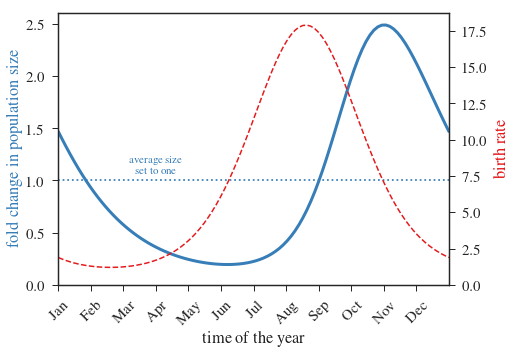

In [2]:
# Parameter values
s = 2.7; φ = 0.42; μ = 7
Ks = exp(s/2)/iv(0,s/2)
print(Ks*μ)
# Birth rate function
### The shift Δt will be used later for adopting curve to Nigeria
B = lambda t, Δt: μ*Ks*exp(-s*cos(np.pi*(t-Δt)-φ)**2)
# Population dynamics
popdyn_rhs = lambda t, N, Δt: [(B(t,Δt)-μ)*N]
# Determining the initial value
ν = 1 # average population size is set to one
νData = 100*integrate.quad(lambda t: exp(integrate.quad(lambda τ: B(τ,0.0)-μ, 0, t)[0]),0,1)[0] # average population size from the data
N0 = lambda Δt: ν/integrate.quad(lambda t: exp(integrate.quad(lambda τ: B(τ,Δt)-μ, 0, t)[0]),0,1)[0]
# Solving population ODE
solver = ode(popdyn_rhs).set_integrator(backend)
solver.set_initial_value([N0(0.0)]) # N will be a fold change in population size relatively to the average population size
solver.set_f_params(0.0) # Δt=0
τs = np.linspace(0,1,100)
Ns = []; k = 0
while (solver.t<max(τs)):
    solver.integrate(τs[k])
    Ns.append(solver.y)
    k += 1
# Plot
plt.rcParams['figure.figsize'] = (7, 5)
fig, ax = plt.subplots()
ax.plot(τs,Ns,color=clrs[1],lw=3)
ax.axhline(y=1,ls="dotted",color=clrs[1],zorder=-5)
ax.set_ylim(ymin=0)
ax.text(.25,1.06,'average size\nset to one',size=11,horizontalalignment='center',color=clrs[1])
ax2 = ax.twinx()
Bs = [B(τ,0) for τ in τs]
ax2.plot(τs,Bs,color=clrs[0],lw=1.5,linestyle="dashed")
ax.set_xlabel("time of the year")
ax.set_ylabel("fold change in population size",color=clrs[1])
ax2.set_ylabel("birth rate",color=clrs[0])
### A bit simplified version for indicating the month in xticklabels
ax.set_xticks(np.linspace(0,1,12,endpoint=False))
ax.set_xticklabels([datetime.date(1900,monthinteger+1,1).strftime('%b') for monthinteger in np.arange(12)])
for label in ax.get_xmajorticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment("center")
ax2.margins(x=0.0)
ax2.set_ylim(ymin=0)

plt.savefig(prefix_dir+"Figure1.pdf",format='pdf',bbox_inches='tight')

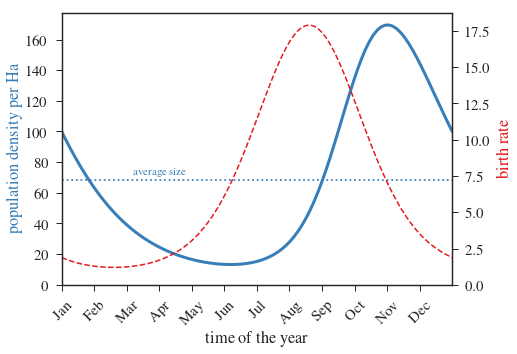

In [3]:
# The same plot but for population size
plt.rcParams['figure.figsize'] = (7, 5)
fig, ax = plt.subplots()
ax.plot(τs,[N*νData for N in Ns],color=clrs[1],lw=3)
ax.axhline(y=νData,ls="dotted",color=clrs[1],zorder=-5)
ax.set_ylim(ymin=0)
ax.text(.25,1.06*νData,'average size',size=11,horizontalalignment='center',color=clrs[1])
ax2 = ax.twinx()
Bs = [B(τ,0) for τ in τs]
ax2.plot(τs,Bs,color=clrs[0],lw=1.5,linestyle="dashed")
ax.set_xlabel("time of the year")
ax.set_ylabel("population density per Ha",color=clrs[1])
ax2.set_ylabel("birth rate",color=clrs[0])
### A bit simplified version for indicating the month in xticklabels
ax.set_xticks(np.linspace(0,1,12,endpoint=False))
ax.set_xticklabels([datetime.date(1900,monthinteger+1,1).strftime('%b') for monthinteger in np.arange(12)])
for label in ax.get_xmajorticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment("center")
ax2.margins(x=0.0)
ax2.set_ylim(ymin=0)

plt.savefig(prefix_dir+"Figure1b.pdf",format='pdf',bbox_inches='tight')

In [4]:
2.4*(.5*7+4.06)

18.144

As we see the seasonal fluctuations of the multimammate mice are quite large and the changes are more than 12-fold over the season.

In [5]:
float(max(Ns)/min(Ns))

12.793889268396299

Due to demographic stochasticity, the amplitude of fluctuations can reach 40-fold ([Mammals of Africa, Vol.1-6, p. 469](http://www.bloomsbury.com/uk/mammals-of-africa-9781408122570/)).

Tanzania and Nigeria have similar economic and climate background. 

The season is subdivided on rainy and dry seasons. In Nigeria the peak of dry season is in Jan-Feb, while in Tanzania it is in the mid of Jun. As it is stated in encyclopedia ([Mammals of Africa, Vol.1-6, p. 469](http://www.bloomsbury.com/uk/mammals-of-africa-9781408122570/)): "Survival of subadult and adult animals is affected in a complex way by combination of density-dependent and density-independent (rainfall) factors (Liers *et al* 1997a)." Hence, the dynamics for population size of multimammate mice in Nigeria have similar characteristics as in Tanzania but to be shifted in time. 

To calculate the relative time shift in the dynamics, we use the data on average rainfall for 1991-2015 [in Nigeria](http://sdwebx.worldbank.org/climateportal/?page=country_historical_climate&ThisRegion=Africa&ThisCCode=NGA), where LF epidemics is the most consistent over last 5 years, and [in Morogoro, Tanzania (6.51S, 37.38E)](http://sdwebx.worldbank.org/climateportal/index.cfm?page=country_historical_climate&ThisRegion=Africa&ThisCCode=TZA), see ([Sluydts et al 2009](http://www.sciencedirect.com/science/article/pii/S0261219409000738)).

By definition (see [Wikipedia](https://en.wikipedia.org/wiki/Wet_season)), the rainy season is when the average precipitation is 60 millimetres or more. We define the beginning of the rainy season by intersection of the rainfall curve with that level of 60mm.

Rainy season in Nigeria starts at t = 0.18 (year length = 1), it ends at t = 0.87 (length = 0.69)
Rainy season in Tanzania starts at t = 0.89, it ends at t = 1.38 (length = 0.49)
Time shift from Tanzania to Nigeria: 0.867-0.382 = 0.49


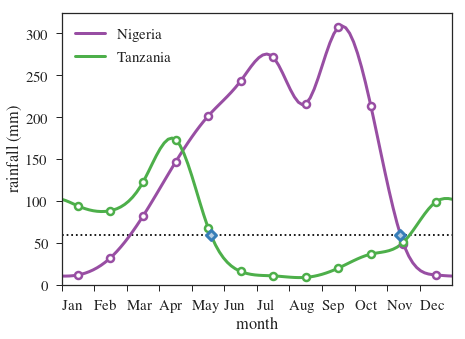

In [6]:
# Extracted monthly data
##in Edo province Nigeria (6.69,6.2)
##rainfallEdoNG = [8.52,24.61,71.44,140.49,202.76,245.12,269.63,240.75,316.08,225.1,38.94,9.44]
##temperatureEdoNG = [26.92,28.74,28.96,28.21,26.97,25.96,25.21,24.96,25.49,26.27,27.25,26.99]
rainfallNG = [11.7182611107826,32.2043484174687,81.9582622776861,146.446959752622,201.333914980681,243.224352496603,271.555656134564,
              216.072176958167,307.379134999151,213.540872988494,49.1565223237743,11.7617393849337]
temperatureNG = [26.92,28.74,28.96,28.21,26.97,25.96,25.21,24.96,25.49,26.27,27.25,26.99]
rainfallTZ = [94.1330444999363,88.4756539386252,122.468697722062,173.360872816003,68.1269578083702,15.9582611379416,10.6669567167759,
              8.86260881832112,19.8878265371141,36.6313051537327,50.7782617506774,99.0608715803727]
temperatureTZ = [26.68,26.82,26.55,25.3,24.3,22.6,22.1,22.77,24.24,25.69,26.82,27.2]
# Time points (mids of the months)
tms = np.arange(0.5,12.5,1)/12
# Spline interpolation
def splinefun(x,X,Y):
    tck = interpolate.splrep(X, Y)
    return float(interpolate.splev(x, tck))
# Plot
plt.rcParams['figure.figsize'] = (7, 5)
fig, ax = plt.subplots()
country_labels = ["Nigeria","Tanzania"]
## Nigeria
ax.scatter(tms,rainfallNG,color=clrs[3],marker='o',facecolor='white',lw=2.5,zorder=5)
ax.plot(τs,[splinefun(t,np.concatenate((tms-1,tms,tms+1),axis=0).tolist(),rainfallNG*3) for t in τs],
        color=clrs[3],lw=3,label=country_labels[0])
rainySeasonNG_start = fsolve(lambda x: splinefun(x,np.concatenate((tms-1,tms,tms+1),axis=0).tolist(),rainfallNG*3)-60.0,x0=.5)[0]
rainySeasonNG_end = fsolve(lambda x: splinefun(x,np.concatenate((tms-1,tms,tms+1),axis=0).tolist(),rainfallNG*3)-60.0,x0=.9)[0]
print("Rainy season in Nigeria starts at t = %.2f (year length = 1), it ends at t = %.2f (length = %.2f)"%(rainySeasonNG_start,rainySeasonNG_end,rainySeasonNG_end-rainySeasonNG_start))
## Tanzania
ax.plot(τs,[splinefun(t,np.concatenate((tms-1,tms,tms+1),axis=0).tolist(),rainfallTZ*3) for t in τs],
        color=clrs[2],lw=3,label=country_labels[1])
ax.scatter(tms,rainfallTZ,color=clrs[2],marker='o',facecolor='white',lw=2.5,zorder=5)
ax.axhline(y=60,ls="dotted",color="black",zorder=-5)
rainySeasonTZ_start = fsolve(lambda x: splinefun(x,np.concatenate((tms-1,tms,tms+1),axis=0).tolist(),rainfallTZ*3)-60.0,x0=.9)[0]
rainySeasonTZ_end = fsolve(lambda x: splinefun(x,np.concatenate((tms-1,tms,tms+1),axis=0).tolist(),rainfallTZ*3)-60.0,x0=.45)[0]
print("Rainy season in Tanzania starts at t = %.2f, it ends at t = %.2f (length = %.2f)"%(rainySeasonTZ_start,rainySeasonTZ_end+1,rainySeasonTZ_end+1-rainySeasonTZ_start))
ax.scatter([rainySeasonTZ_end,rainySeasonNG_end],[60]*2,color=clrs[1],marker='D',zorder=5,s=50,facecolor=pstl[1],lw=3)
# Time shift
Δt = rainySeasonNG_end-rainySeasonTZ_end
print("Time shift from Tanzania to Nigeria: %.3f-%.3f = %.2f"%(rainySeasonNG_end,rainySeasonTZ_end,Δt))
ax.legend(loc=2)
### A bit simplified version for indicating the month in xticklabels
ax.set_xlabel("month")
ax.set_ylabel("rainfall (mm)")
ax.set_xticks(np.linspace(0,1,12,endpoint=False))
ax.set_xticklabels([datetime.date(1900,monthinteger+1,1).strftime('%b') for monthinteger in np.arange(12)])
for label in ax.get_xmajorticklabels():
    label.set_rotation(0)
    label.set_horizontalalignment('left')
ax.margins(x=0.0)
ax.set_ylim(ymin=0);

plt.savefig(prefix_dir+"Figure2-1.pdf",format='pdf',bbox_inches='tight')

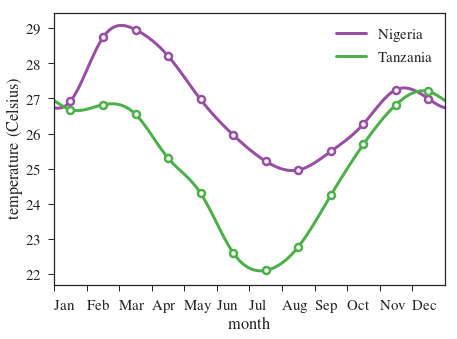

In [7]:
plt.rcParams['figure.figsize'] = (7, 5)
fig, ax = plt.subplots()
country_labels = ["Nigeria","Tanzania"]
## Nigeria
ax.scatter(tms,temperatureNG,color=clrs[3],marker='o',facecolor='white',lw=2.5,zorder=5)
ax.plot(τs,[splinefun(t,np.concatenate((tms-1,tms,tms+1),axis=0).tolist(),temperatureNG*3) for t in τs],
        color=clrs[3],lw=3,label=country_labels[0])
## Tanzania
ax.scatter(tms,temperatureTZ,color=clrs[2],marker='o',facecolor='white',lw=2.5,zorder=5)
ax.plot(τs,[splinefun(t,np.concatenate((tms-1,tms,tms+1),axis=0).tolist(),temperatureTZ*3) for t in τs],
        color=clrs[2],lw=3,label=country_labels[1])
ax.legend(loc=1)
### A bit simplified version for indicating the month in xticklabels
ax.set_xlabel("month")
ax.set_ylabel("temperature (Celsius)") #°
ax.set_xticks(np.linspace(0,1,12,endpoint=False))
ax.set_xticklabels([datetime.date(1900,monthinteger+1,1).strftime('%b') for monthinteger in np.arange(12)])
for label in ax.get_xmajorticklabels():
    label.set_rotation(0)
    label.set_horizontalalignment("left")
ax.margins(x=0.0)

plt.savefig(prefix_dir+"Figure2-2.pdf",format='pdf',bbox_inches='tight')

In the following plot the gradient of grey indicates the average amount of rainfall

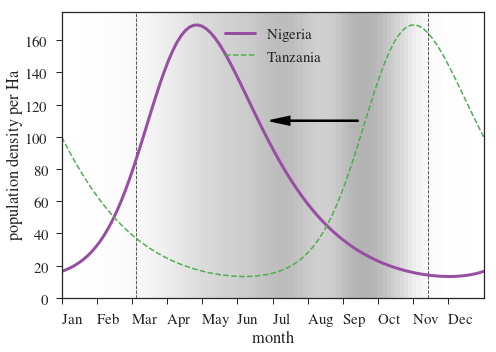

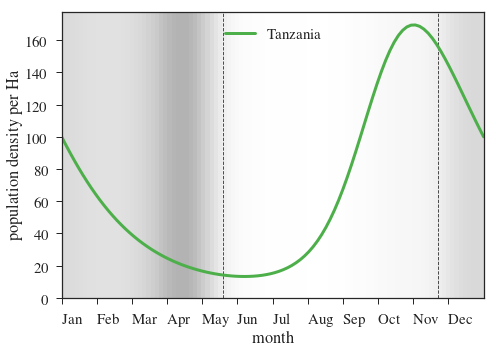

In [8]:
# Determining the initial value
N0 = lambda Δt: ν/integrate.quad(lambda t: exp(integrate.quad(lambda τ: B(τ,Δt)-μ, 0, t)[0]),0,1)[0]
# Plots
plt.rcParams['figure.figsize'] = (7, 5)
ax.axhline(y=1,ls="dotted",color="grey",zorder=-5)
# Solving population ODE for Tanzania (Δt=0) and Nigeria (Δt=0.45)
solver = ode(popdyn_rhs).set_integrator(backend)
τs = np.linspace(0,1,100)
rainfall = [rainfallNG,rainfallTZ]
xlb = ["month"]*2
lc = [9,9]
for i, δt in enumerate([Δt,0]): 
    fig, ax = plt.subplots()
    solver.set_initial_value([N0(δt)]) 
    solver.set_f_params(δt)
    Ns = []; k = 0
    while (solver.t<max(τs)):
        solver.integrate(τs[k])
        Ns.append(solver.y)
        k += 1
    ax.plot(τs,[N*νData for N in Ns],color=clrs[3-i],lw=3,label=country_labels[i])
    if (i==0):
        solver.set_initial_value([N0(0)]) 
        solver.set_f_params(0)
        Ns = []; k = 0
        while (solver.t<max(τs)):
            solver.integrate(τs[k])
            Ns.append(solver.y)
            k += 1
        ax.plot(τs,[N*νData for N in Ns],color=clrs[2],lw=1.5,ls="dashed",label=country_labels[1])
        ax.arrow(.702,110,-.162,0,fc="k",ec="k",head_width=5,head_length=.045,lw=2)
    ax.legend(loc=lc[i])
    ax.margins(x=0.0)
    ax.set_ylim(ymin=0)
    if i:
        [ax.axvline(x=t,lw=.9,ls="dashed",color="black",zorder=-5) for t in [rainySeasonTZ_start,rainySeasonTZ_end]]
    else:
        [ax.axvline(x=t,lw=.9,ls="dashed",color="black",zorder=-5) for t in [rainySeasonNG_start,rainySeasonNG_end]]
    ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),
          np.array([splinefun(t,np.concatenate((tms-1,tms,tms+1),axis=0).tolist(),rainfall[i]*3) for t in τs])[np.newaxis],
          cmap='Greys', alpha=0.3)
    ax.set_xlabel(xlb[i])
    ax.set_ylabel("population density per Ha")
    ### A bit simplified version for indicating the month in xticklabels
    ax.set_xticks(np.linspace(0,1,12,endpoint=False))
    ax.set_xticklabels([datetime.date(1900,monthinteger+1,1).strftime('%b') for monthinteger in np.arange(12)])
    for label in ax.get_xmajorticklabels():
        label.set_rotation(0)
        label.set_horizontalalignment("left")
    plt.tight_layout()
    plt.savefig(prefix_dir+"Figure3-"+str(2-i)+".pdf",format='pdf',bbox_inches='tight')

Here we notice that the average population size for Nigeria and Tanzania can be different.

To develop further our model and make it applicable to the Lassa fever, we account for the following facts, see ([Fichet-Calvet *et al* 2014](http://dx.doi.org/10.1089/vbz.2013.1484)):
* LF is asymptomatic in rodents.
* LF prevalence is higher in rainy seasons
    1. One time measurement during dry season showed the prevalence at 29%;
    2. One time measurement during dry season and four times measurement during rainy season revealed the prevalence to be at level of 43%.
        Thus, a simple maths may show: $\frac15\cdot 29\%+\frac{4}5\cdot x=43\%$, which gives the prevalence $x=46.5\%$ during the rainy season.
* Infection is transient, clearing the blood from the virus after the infection.
* Virus is secreted in urine up to 103 days.
* There is *horizontal* and *vertical* transmission in rodents. Infection is transferred *in utero*.
* Mortality in rodents is high. It is rare to find an adult surviving for the next dry season. (Indeed, we have $\mu=7$)
* Contact rate $\beta$ is density-dependent. It has a sigmoid-like form that was shown in a study in Tanzania ([Borremans *et al* 2016](http://dx.doi.org/10.1111/oik.03623)). Thus, we should take this into account in our further development of the model. In *Ecology* it is known under the name of allee effect (see *e.g.* Murray).

**Finally**, we arrive to the following form of the dynamical equations:
$$\begin{aligned} &\frac{\mathrm dS}{\mathrm dt} = B(t)\left[S+(1-\varepsilon)I+(1-\vartheta)R\right] -\frac{\beta SI}N+\lambda R-\mu S,\\ &\frac{\mathrm dI}{\mathrm dt} = \varepsilon B(t)I+\frac{\beta SI}N-(\gamma+\mu)I,\\ &\frac{\mathrm dR}{\mathrm dt} = \vartheta B(t)R + \gamma I-(\lambda+\mu)R, \end{aligned}$$
where $S$ stands for susceptible mice, $I$ for infected, and $R$ for immune to the infection. $\varepsilon$ and $\vartheta$ describe the probability of vertical transmission of the infection and antibodies respectively. Thus, the joint compartment $R+I$ is for seropositive mice. 

What we want to track from here is the prevalence level $x=\frac IN$ and fraction of immune mice $p=\frac RN$. We derive the final form of the dynamics:
$$\begin{aligned} &\frac{\mathrm dN}{\mathrm dt}=(B(t)-\mu)N,\\ &\frac{\mathrm dx}{\mathrm dt} = \beta x(1-p-x)-\left((1-\varepsilon)B(t)+\gamma\right)x,\\ &\frac{\mathrm dp}{\mathrm dt} = \gamma x-\left((1-\vartheta)B(t)+\lambda\right)p.\end{aligned}$$
The incidence equals to $i=\beta x(1-x)N$.

In particular case of complete vertical transmission of infection and antibodies ($\varepsilon=\vartheta=1$), the dynamics of infection stabilizes at level $(x^*,p^*)$:
$$x^*=1-\frac\gamma\beta,\quad p^*=\frac\gamma\vartheta x^*=\frac\gamma\vartheta\left(1-\frac\gamma\beta\right).$$
*However*, the prevalence level and immunity level vary over the season, so $\varepsilon$ and  $\vartheta$ should be less than one.

Remember also that $R_0=\frac{\beta}{(1-\varepsilon)\mu+\gamma}$.

Again, we impose **peridocity conditions** for evolution of $x$ and $p$ over the season. We choose the initial values $x(0)$ and $p(0)$ in such a way that:
$$x(0)=x(1),\quad p(0)=p(1).$$

We use ([Fichet-Calvet *et al* 2014](http://dx.doi.org/10.1089/vbz.2013.1484)) to set the following parameter values: 
* Length of viramia of 90 days: $\gamma=\frac{1}{90\,\mathrm{days}}=\frac{365}{90}\,\mathrm{years}^{-1}=4.056\,\mathrm{y}^{-1}$.
* Loss of immunity within 120 days: $\lambda=\frac{1}{120\,{\mathrm{days}}}=\frac{365}{120}\,{\mathrm{years}^{-1}}=3.042\,\mathrm{y}^{-1}$.
* 20% of newborns acquire maternal antibodies: $\vartheta=0.2$.
* Vertical transmission 50%: $\varepsilon=0.5$.

In [10]:
# Parameter values
γ = 365/90
print("γ = %.3f"%γ)
λ = 365/120
print("λ = %.3f"%λ)
ϑ = 0.2
ε = 0.5

γ = 4.056
λ = 3.042


What we actually vary in our simulation is the basic reproduction number among rodents $R_0$. For now, we also assume that there is no allee effect and the contact rate is constant along the season.

In [11]:
# Population dynamics
def dyn_rhs(t, state, R0): 
    N, x, p = state
    dN = (B(t,Δt)-μ)*N
    dx = (γ+μ*(1-ε))*R0*x*(1-p-x)-((1-ε)*B(t,Δt)+γ)*x
    dp = γ*x-((1-ϑ)*B(t,Δt)+λ)*p
    return [dN,dx,dp]
# Setting up the solver for ODE
def dynamicsNXP(τs,x0,p0,R0):
    solver = ode(dyn_rhs).set_integrator(backend)
    solver.set_initial_value([N0(Δt),x0,p0]).set_f_params(R0)
    sol = []; k = 0
    while (solver.t<max(τs)):
        solver.integrate(τs[k])
        sol.append([solver.t]+list(solver.y))
        k += 1
    return sol

A particular example for $x(0)=0.29$, $p(0)=0.5$, and $R_0=2.5$ (non-periodic solution) 

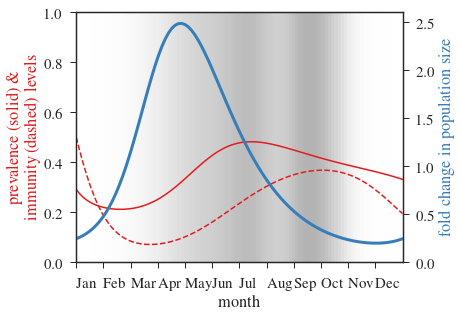

In [12]:
plt.rcParams['figure.figsize'] = (6.5, 4.5)
τs = np.linspace(0,1,100)
sol = dynamicsNXP(τs,.29,.5,2.5)
fig, ax = plt.subplots(); ax2 = ax.twinx()
ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),
              np.array([splinefun(t,np.concatenate((tms-1,tms,tms+1),axis=0).tolist(),rainfallNG*3) for t in τs])[np.newaxis],
              cmap='Greys', alpha=0.3)
ax.plot([x[0] for x in sol],[x[2] for x in sol],color=clrs[0],lw=1.5,linestyle="solid")
ax.plot([x[0] for x in sol],[x[3] for x in sol],color=clrs[0],lw=1.5,linestyle="dashed")
ax2.plot([x[0] for x in sol],[x[1] for x in sol],color=clrs[1],lw=3)
ax.set_ylim([0,1])
ax.set_xlabel("month")
ax.set_ylabel("prevalence (solid) \& \nimmunity (dashed) levels",color=clrs[0])
ax2.set_ylabel("fold change in population size",color=clrs[1])
### A bit simplified version for indicating the month in xticklabels
ax.set_xticks(np.linspace(0,1,12,endpoint=False))
ax.set_xticklabels([datetime.date(1900,monthinteger+1,1).strftime('%b') for monthinteger in np.arange(12)])
for label in ax.get_xmajorticklabels():
    label.set_rotation(0)
    label.set_horizontalalignment("left")
ax2.margins(x=0.0)
ax2.set_ylim(ymin=0)
plt.tight_layout()

where the gradient of grey indicates the amount of rainfall.

Now we identify the periodic solution.

In [13]:
### Here is the function that gives two values x(1) and p(1) depending on x(0) and p(0) as input variables
def periodicFuncXP(xpInits,R0):
    x0, p0 = xpInits
    solver = ode(dyn_rhs).set_integrator(backend)
    solver.set_initial_value([N0(Δt),x0,p0]).set_f_params(R0).integrate(1.0)
    return list(solver.y[1:]-[x0,p0])

In [14]:
# Particular value of R0
R0p = 2.5
# Example
periodicFuncXP([.2,.5],R0p)

[0.1308250320601685, -0.30657477995799187]

In [15]:
solPeriodic0 = list(fsolve(periodicFuncXP,(0.56, 0.16),args=(R0p,)))
solPeriodic0

[0.33009196105051186, 0.19308183692533554]

(0, 2.606254839031971)

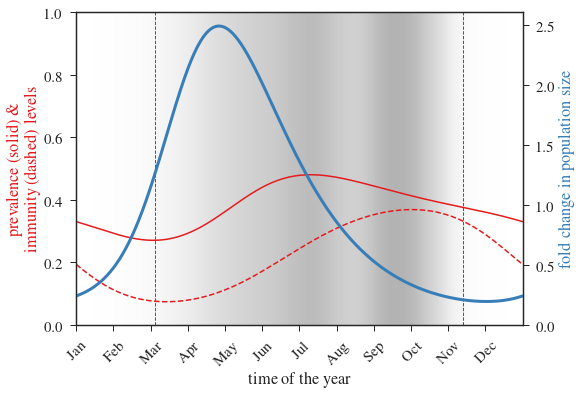

In [16]:
plt.rcParams['figure.figsize'] = (8, 5.75)
τs = np.linspace(0,1,1e3)
sol = dynamicsNXP(τs,solPeriodic0[0],solPeriodic0[1],R0p)
fig, ax = plt.subplots(); ax2 = ax.twinx()
ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),
              np.array([splinefun(t,np.concatenate((tms-1,tms,tms+1),axis=0).tolist(),rainfallNG*3) for t in τs])[np.newaxis],
              cmap='Greys', alpha=0.3)
[ax.axvline(x=t,lw=.9,ls="dashed",color="black",zorder=-5) for t in [rainySeasonNG_start,rainySeasonNG_end]]
ax.plot([x[0] for x in sol],[x[2] for x in sol],color=clrs[0],lw=1.5,linestyle="solid")
ax.plot([x[0] for x in sol],[x[3] for x in sol],color=clrs[0],lw=1.5,linestyle="dashed")
ax2.plot([x[0] for x in sol],[x[1] for x in sol],color=clrs[1],lw=3)
ax.set_ylim([0,1])
ax.set_xlabel("time of the year")
ax.set_ylabel("prevalence (solid) \& \nimmunity (dashed) levels",color=clrs[0])
ax2.set_ylabel("fold change in population size",color=clrs[1])
### A bit simplified version for indicating the month in xticklabels
ax.set_xticks(np.linspace(0,1,12,endpoint=False))
ax.set_xticklabels([datetime.date(1900,monthinteger+1,1).strftime('%b') for monthinteger in np.arange(12)])
for label in ax.get_xmajorticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment("center")
ax2.margins(x=0.0)
ax2.set_ylim(ymin=0)
# plt.tight_layout()

In [17]:
list(np.array(sol).min(axis=0))[1:], list(np.array(sol).max(axis=0))[1:]

([0.19463681296285257, 0.27041077608446906, 0.07388883392797581], [2.491415885
4096318, 0.48019110996367403, 0.3687476657267337])

In [18]:
from pathlib import Path
datafile = "../results/rodents_solPeriodic.pkl"
recalc = False

In [19]:
if (recalc|(not Path(datafile).is_file())):
    R0s = np.linspace(5.5,.5,501)
    x0i = .5; p0i = .19
    solPeriodic = []
    for R0 in R0s:
        x0i, p0i = list(fsolve(periodicFuncXP,(x0i,p0i),args=(R0,)))
        soli = dynamicsNXP(τs,x0i,p0i,R0)
        res = [R0,x0i,p0i,min([x[2] for x in soli]),max([x[2] for x in soli]),
              np.mean([x[2] for x in soli if (x[0]<rainySeasonNG_start)|(x[0]>rainySeasonNG_end)]),
              np.mean([x[2] for x in soli if (x[0]>=rainySeasonNG_start)&(x[0]<=rainySeasonNG_end)])]
        print(res)
        solPeriodic.append(res)
        
    # Saving the data
    file_to_save = open(datafile,'wb')
    pickle.dump(solPeriodic, file_to_save)
    file_to_save.close()
    
    recalc = False
else:
    # Loading the data
    file_to_load = open(datafile,'rb')
    solPeriodic = pickle.load(file_to_load)
    file_to_load.close()

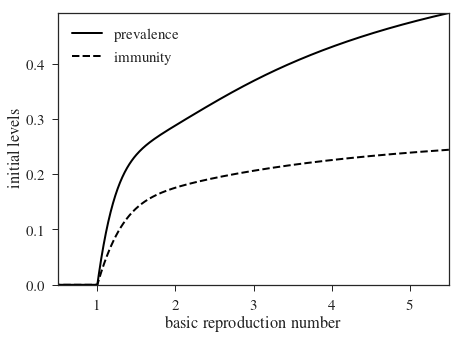

In [20]:
plt.rcParams['figure.figsize'] = (7, 5)
fig, ax = plt.subplots()
ax.plot([x[0] for x in solPeriodic],[x[1] for x in solPeriodic],color="k",lw=2,linestyle="solid",label="prevalence")
ax.plot([x[0] for x in solPeriodic],[x[2] for x in solPeriodic],color="k",lw=2,linestyle="dashed",label="immunity")
ax.set_xlabel("basic reproduction number")
ax.set_ylabel("initial levels")
ax.legend(loc=2)
ax.margins(0.0)

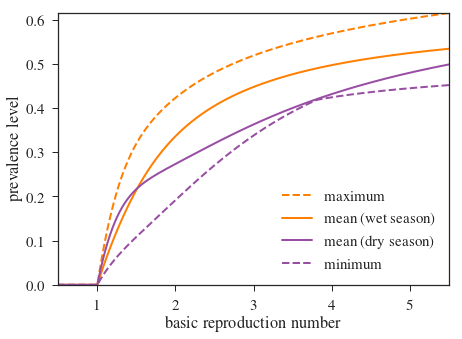

In [21]:
plt.rcParams['figure.figsize'] = (7, 5)
fig, ax = plt.subplots()
ax.plot([x[0] for x in solPeriodic],[x[4] for x in solPeriodic],color=clrs[4],lw=2,linestyle="dashed",label="maximum")
ax.plot([x[0] for x in solPeriodic],[x[6] for x in solPeriodic],color=clrs[4],lw=2,linestyle="solid",label="mean (wet season)")
ax.plot([x[0] for x in solPeriodic],[x[5] for x in solPeriodic],color=clrs[3],lw=2,linestyle="solid",label="mean (dry season)")
ax.plot([x[0] for x in solPeriodic],[x[3] for x in solPeriodic],color=clrs[3],lw=2,linestyle="dashed",label="minimum")
ax.set_xlabel("basic reproduction number")
ax.set_ylabel("prevalence level")
ax.legend(loc=4)
ax.margins(0.0)
plt.savefig(prefix_dir+"Figure4a.pdf",format='pdf',bbox_inches='tight')

### $\chi^2$-statistics

In [22]:
χ2value = [[x[0],(.465-x[6])**2/x[6]+(.29-x[5])**2/x[5]] for x in solPeriodic if x[0]>1]
χ2_argminindex = np.argmin([x[1] for x in χ2value])
χ2value[χ2_argminindex]
print(solPeriodic[χ2_argminindex])
solC = solPeriodic[χ2_argminindex]
R0c, x0c, p0c = solC[0:3]
xdry0c, xwet0c = solC[len(solC)-2:]
R0c, x0c, p0c

[2.65, 0.34214262354930247, 0.19731903457844832, 0.29201678895664146, 0.4931763885371211, 0.3331609475042784, 0.4196537600017376]


(2.65, 0.34214262354930247, 0.19731903457844832)

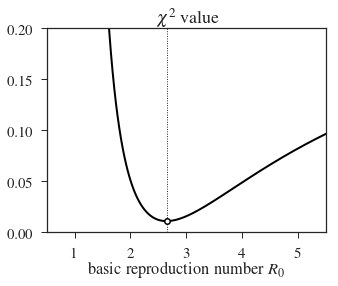

In [23]:
# Plot
plt.rcParams['figure.figsize'] = (5, 3.75)
fig, ax = plt.subplots()
ax.plot([x[0] for x in χ2value],[x[1] for x in χ2value],color="k",lw=2,linestyle="solid")
ax.set_xlabel(r"basic reproduction number $R_0$")
ax.set_title(r"$\chi^2$ value")
ax.margins(0.0)
ax.set_xlim([.5,5.5])
ax.set_ylim([0,.2])
ax.set_xticks(np.arange(1,6))
ax.set_yticks(np.linspace(0,.2,5))
ax.axvline(x=R0c,lw=.9,linestyle="dotted",color="k",zorder=-5)
ax.scatter([R0c],[χ2value[χ2_argminindex][1]],zorder=5,marker='o',edgecolors='k',facecolors='w',lw=1.5,s=30)
plt.savefig(prefix_dir+"Figure5d.pdf",format='pdf',bbox_inches='tight')

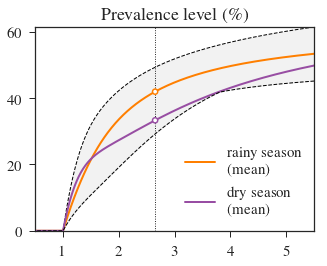

In [24]:
plt.rcParams['figure.figsize'] = (5, 3.75)
fig, ax = plt.subplots()
ax.plot([x[0] for x in solPeriodic],[x[4]*100 for x in solPeriodic],color="k",lw=1,linestyle="dashed")
ax.plot([x[0] for x in solPeriodic],[x[6]*100 for x in solPeriodic],color=clrs[4],lw=2,linestyle="solid",label="rainy season\n(mean)")
ax.plot([x[0] for x in solPeriodic],[x[5]*100 for x in solPeriodic],color=clrs[3],lw=2,linestyle="solid",label="dry season\n(mean)")
ax.plot([x[0] for x in solPeriodic],[x[3]*100 for x in solPeriodic],color="k",lw=1,linestyle="dashed")

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
verts = list(zip([x[0] for x in solPeriodic]+[x[0] for x in solPeriodic][::-1],
                 [x[4]*100 for x in solPeriodic]+[x[3]*100 for x in solPeriodic][::-1]))
ax.add_collection(PatchCollection([Polygon(verts)],color="k",alpha=0.05))

ax.axvline(x=R0c,lw=.9,linestyle="dotted",color="k",zorder=-5)
ax.scatter([R0c]*2,[xdry0c*100,xwet0c*100],edgecolors=[clrs[3],clrs[4]],facecolors='w',lw=1.5,s=27,zorder=5)
# ax.set_xlabel("basic reproduction number")
ax.xaxis.label.set_visible(False)
ax.set_title("Prevalence level (\%)")
ax.set_xlim([.5,5.5])
ax.legend(loc=4)
ax.margins(0.0)
plt.savefig(prefix_dir+"Figure5c.pdf",format='pdf',bbox_inches='tight')

In [25]:
[xdry0c*100,xwet0c*100]

[33.31609475042784, 41.96537600017376]

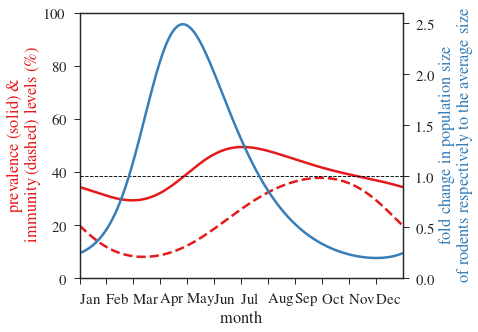

In [26]:
plt.rcParams['figure.figsize'] = (6.75, 4.75)
τs = np.linspace(0,1,1e3)
sol = dynamicsNXP(τs,x0c,p0c,R0c)
fig, ax = plt.subplots(); ax2 = ax.twinx()
# ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),
#               np.array([splinefun(t,np.concatenate((tms-1,tms,tms+1),axis=0).tolist(),rainfallNG*3) for t in τs])[np.newaxis],
#               cmap='Greys', alpha=0.3)
# [ax.axvline(x=t,lw=.9,ls="dashed",color="black",zorder=-5) for t in [rainySeasonNG_start,rainySeasonNG_end]]
ax2.axhline(y=1,lw=.9,ls="dashed",color="black",zorder=-5)
ax.plot([x[0] for x in sol],[x[2] for x in sol],color=clrs[0],lw=2.5,linestyle="solid")
ax.plot([x[0] for x in sol],[x[3] for x in sol],color=clrs[0],lw=2.5,linestyle="dashed")
ax2.plot([x[0] for x in sol],[x[1] for x in sol],color=clrs[1],lw=2.5)
ax.set_ylim([0,1])
ax.set_xlabel("month")
ax.set_ylabel("prevalence (solid) \& \nimmunity (dashed) levels (\%)",color=clrs[0])
ax2.set_ylabel("fold change in population size\nof rodents respectively to the average size",color=clrs[1])
### A bit simplified version for indicating the month in xticklabels
ax.set_xticks(np.linspace(0,1,12,endpoint=False))
ax.set_xticklabels([datetime.date(1900,monthinteger+1,1).strftime('%b') for monthinteger in np.arange(12)])
ytks = np.linspace(0,1,6)
ax.set_yticks(ytks)
ax.set_yticklabels([int(y*100) for y in ytks])
for label in ax.get_xmajorticklabels():
#     label.set_rotation(45)
#     label.set_horizontalalignment("center")
    label.set_horizontalalignment("left")
ax2.margins(x=0.0)
ax2.set_ylim(ymin=0)
plt.tight_layout()

plt.savefig(prefix_dir+"Figure5b.pdf",format='pdf',bbox_inches='tight')

If we assume that the average population densities of rodents in Tanzania and Nigeria are similar, we may use the actual numbers for population density instead of fold change.

Precisely speaking, the fit ([Borremans *et al* 2017](http://dx.doi.org/10.1101/101535)) gives the following average density over the season:

where we took $N(0)=100$ for Tanzania.

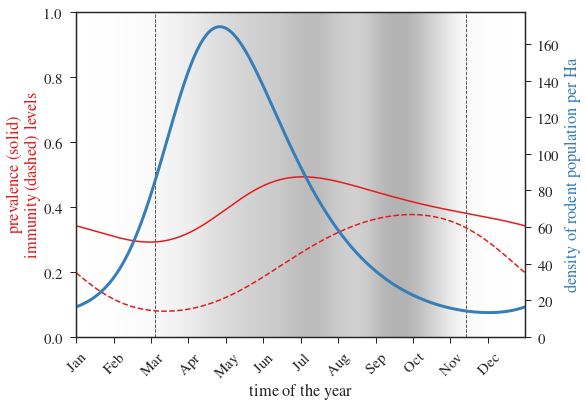

In [27]:
plt.rcParams['figure.figsize'] = (8.25, 5.75)
τs = np.linspace(0,1,1e3)
sol = dynamicsNXP(τs,x0c,p0c,R0c)
fig, ax = plt.subplots(); ax2 = ax.twinx()
ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),
              np.array([splinefun(t,np.concatenate((tms-1,tms,tms+1),axis=0).tolist(),rainfallNG*3) for t in τs])[np.newaxis],
              cmap='Greys', alpha=0.3)
[ax.axvline(x=t,lw=.9,ls="dashed",color="black",zorder=-5) for t in [rainySeasonNG_start,rainySeasonNG_end]]
ax.plot([x[0] for x in sol],[x[2] for x in sol],color=clrs[0],lw=1.5,linestyle="solid")
ax.plot([x[0] for x in sol],[x[3] for x in sol],color=clrs[0],lw=1.5,linestyle="dashed")
ax2.plot([x[0] for x in sol],[x[1]*νData for x in sol],color=clrs[1],lw=3)
ax.set_ylim([0,1])
ax.set_xlabel("time of the year")
ax.set_ylabel("prevalence (solid) & \nimmunity (dashed) levels",color=clrs[0])
ax2.set_ylabel("density of rodent population per Ha",color=clrs[1])
### A bit simplified version for indicating the month in xticklabels
ax.set_xticks(np.linspace(0,1,12,endpoint=False))
ax.set_xticklabels([datetime.date(1900,monthinteger+1,1).strftime('%b') for monthinteger in np.arange(12)])
for label in ax.get_xmajorticklabels():
    label.set_rotation(45)
    label.set_horizontalalignment("center")
ax2.set_ylim(ymin=0)
ax2.margins(0.0)
plt.tight_layout()

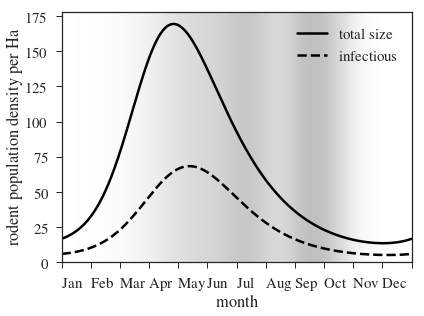

In [28]:
plt.rcParams['figure.figsize'] = (6, 4.5)
from matplotlib.ticker import FixedLocator
fig, ax = plt.subplots()
ax.plot([x[0] for x in sol],[x[1]*νData for x in sol],color="k",lw=2.5,label="total size")
y = [x[1]*νData*x[2] for x in sol]

ax.plot([x[0] for x in sol],y,color="k",lw=2.5,linestyle="--",label="infectious")
# ax.plot([x[0] for x in sol],[x[1]*νData*x[3] for x in sol],color=clrs[0],lw=1.5,linestyle="dashed",label="immune")
# [ax.axvline(x=t,lw=.9,ls="dashed",color="grey",zorder=-5) for t in [rainySeasonNG_start,rainySeasonNG_end]]
ax.margins(x=0.0)
ax.set_ylim(ymin=0)
ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),
              np.array([splinefun(t,np.concatenate((tms-1,tms,tms+1),axis=0).tolist(),rainfallNG*3) for t in τs])[np.newaxis],
              cmap='Greys', alpha=0.25)
ax.set_xlabel("month")
ax.set_ylabel("rodent population density per Ha")
### A bit simplified version for indicating the month in xticklabels
ax.set_xticks(list(np.linspace(0,1,13,endpoint=True)))
ax.set_xticklabels([datetime.date(1900,monthinteger+1,1).strftime('%b') for monthinteger in np.arange(12)])
for label in ax.get_xmajorticklabels():
#     label.set_rotation(45)
#     label.set_horizontalalignment("center")
    label.set_horizontalalignment("left")
ax.legend(loc=1)
# ax.xaxis.label.set_visible(False)
plt.tight_layout()

plt.savefig(prefix_dir+"Figure5a.pdf",format='pdf')

In [29]:
maxs = lambda a: np.r_[True, a[1:] < a[:-1]] & np.r_[a[:-1] < a[1:], True]

In [30]:
from operator import itemgetter
index, element = max(enumerate(y), key=itemgetter(1))
element

68.18854787510547

In [31]:
index/len(y)

0.365

In [32]:
element/np.mean(y)

2.5183532614683224

In [33]:
from operator import itemgetter
index, element = max(enumerate([-y for y in y]), key=itemgetter(1))
element

-4.84466188787324

In [34]:
index/len(y)

0.931

In [35]:
β = R0c*((1-ε)*μ+γ)
β

20.022222222222222

Average density of infected rodents

In [36]:
Imean = np.mean([x[1]*νData*x[2] for x in sol])
Imean

27.076641279209667

In [37]:
Imean/68.05*100

39.78933325379819

Maximum and minimum number of infected rodents

In [38]:
# Maximum
index0 = np.argmax([x[1]*νData*x[2] for x in sol])
sol[index0]

[0.36536536536536535, 2.3622204866636896, 0.4241989465542793, 0.14315600033221
745]

In [39]:
sol[index0][1]*νData*sol[index0][2]/Imean-1

1.5183532614683224

In [40]:
# Minimum
index0 = np.argmin([x[1]*νData*x[2] for x in sol])
sol[index0]+[sol[index0][1]*νData*sol[index0][2]]

[0.9319319319319319, 0.19565117317589956, 0.36388117781027796, 0.2776103227295
731, 4.84466188787324]

In [41]:
1-sol[index0][1]*νData*sol[index0][2]/Imean

0.8210759658882385

In [42]:
list(np.linspace(0,1,13,endpoint=True))

[0.0, 0.08333333333333333, 0.16666666666666666, 0.25, 0.3333333333333333, 0.41
666666666666663, 0.5, 0.5833333333333333, 0.6666666666666666, 0.75, 0.83333333
33333333, 0.9166666666666666, 1.0]

In [43]:
tmes = np.linspace(0,1,53)
inf_mice = []
for i in np.arange(len(tmes)-1):
    inf_mice.append(np.mean([x[1]*νData*x[2] for x in sol if (x[0]>=tmes[i])&(x[0]<tmes[i+1])]))
inf_mice

[5.875874954625212, 6.5626881195019635, 7.478032302212205, 8.693943737442543, 
10.329209672168684, 12.43439330850854, 15.026196805970917, 18.221862393225006,
 22.06913803776942, 26.703873118649444, 31.966711592017358, 37.57429833991498,
 43.4454895516422, 49.3081014050299, 54.982151020486675, 59.969961110387395, 6
3.85795727117887, 66.56092473189797, 67.95861466027647, 67.95409970541377, 66.
66371339883689, 64.27274144796758, 60.997452069095445, 56.96688803572827, 52.5
1824216746665, 47.996417499411564, 43.47045910201997, 39.0772433639384, 34.809
945150308934, 30.850072599901026, 27.32596837568047, 24.142175645024327, 21.29
456655989876, 18.70754680512956, 16.433662024723823, 14.497910101844708, 12.81
1178795497664, 11.313423624021286, 10.023828929542145, 8.947634715479959, 8.02
8930170218155, 7.250728125879509, 6.5834991308152, 6.035154874868885, 5.607122
848440883, 5.276773081059019, 5.040251289194284, 4.894665530971838, 4.84913365
820517, 4.9093746598883605, 5.084551696874979, 5.392

In [44]:
# tmes = np.linspace(0,1,27)
# inf_mice = []
# for i in np.arange(len(tmes)-1):
#     inf_mice.append(np.mean([x[1]*νData*x[2] for x in sol if (x[0]>=tmes[i])&(x[0]<tmes[i+1])]))
# inf_mice

In [45]:
# Emean = pd.read_csv("../results/Emean.csv").x.tolist()
# Emean

In [46]:
Aminus = 9.11969437
Aplus = 38.23233172	
i1 = 8; i2 = 44
Emean = []
for week in np.arange(1,53,1):
    if (week>=i1 and week<=i2):
        Emean.append(Aminus)
    else:
        Emean.append(Aplus)

tms_ = np.linspace(0,1,1e3)
contact_rate = [x/y for x,y in zip(Emean,inf_mice)]

Emean

[38.23233172, 38.23233172, 38.23233172, 38.23233172, 38.23233172, 38.23233172,
 38.23233172, 9.11969437, 9.11969437, 9.11969437, 9.11969437, 9.11969437, 9.11
969437, 9.11969437, 9.11969437, 9.11969437, 9.11969437, 9.11969437, 9.11969437
, 9.11969437, 9.11969437, 9.11969437, 9.11969437, 9.11969437, 9.11969437, 9.11
969437, 9.11969437, 9.11969437, 9.11969437, 9.11969437, 9.11969437, 9.11969437
, 9.11969437, 9.11969437, 9.11969437, 9.11969437, 9.11969437, 9.11969437, 9.11
969437, 9.11969437, 9.11969437, 9.11969437, 9.11969437, 9.11969437, 38.2323317
2, 38.23233172, 38.23233172, 38.23233172, 38.23233172, 38.23233172, 38.2323317
2, 38.23233172]

In [75]:
# dry season
tmes_ = (np.arange(len(tmes)-1)+.5)/(len(tmes)-1)
exp_dry = np.mean([y for t,y in zip(tmes_,contact_rate) if (t<(i1+.5)/52)|(t>(i2+0.5)/52)])
# wet season
exp_wet = np.mean([y for t,y in zip(tmes_,contact_rate) if (t>=(i1+.5)/52)&(t<=(i2+0.5)/52)])
# hazard ratio
ratio = exp_dry/exp_wet
exp_dry, exp_wet, ratio

(5.6390694737731915, 0.6179229542871845, 9.125845600408608)

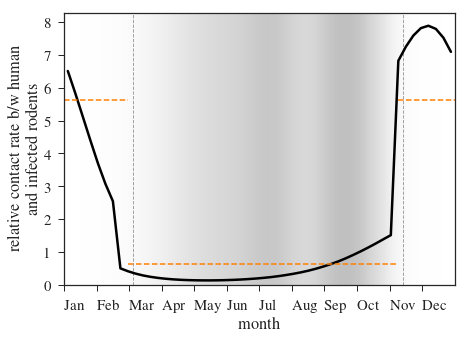

In [76]:
plt.rcParams['figure.figsize'] = (7, 5)
fig, ax = plt.subplots()
tmes_ = (np.arange(len(tmes)-1)+.5)/(len(tmes)-1)
contact_rate = [x/y for x,y in zip(Emean,inf_mice)]
ax.plot(tmes_,contact_rate,color="k",lw=2.5,linestyle="solid")
ax.margins(x=0.0)
ax.set_xlim([0,1])
ax.set_ylim(ymin=0)
[ax.axvline(x=t,lw=.9,ls="dashed",color="grey",zorder=-5) for t in [rainySeasonNG_start,rainySeasonNG_end]]
ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),
              np.array([splinefun(t,np.concatenate((tms-1,tms,tms+1),axis=0).tolist(),rainfallNG*3) for t in τs])[np.newaxis],
              cmap='Greys', alpha=0.25)
ax.set_xlabel("month")
ax.set_ylabel("relative contact rate b/w human \n and infected rodents")
### A bit simplified version for indicating the month in xticklabels
ax.set_xticks(np.linspace(0,1,12,endpoint=False))
ax.set_xticklabels([datetime.date(1900,monthinteger+1,1).strftime('%b') for monthinteger in np.arange(12)])
for label in ax.get_xmajorticklabels():
#     label.set_rotation(45)
#     label.set_horizontalalignment("center")
    label.set_horizontalalignment("left")
ax.margins(0.0)

t_ = [t for t in tms_ if (t<(i1+.5)/52)]
ax.plot(t_,len(t_)*[exp_dry],color=clrs[4],lw=1.5,linestyle="dashed",zorder=2)
t_ = [t for t in tms_ if (t>(i2+0.5)/52)]
ax.plot(t_,len(t_)*[exp_dry],color=clrs[4],lw=1.5,linestyle="dashed",zorder=2)
t_ = [t for t in tms_ if (t>=(i1+.5)/52)&(t<=(i2+0.5)/52)]
ax.plot(t_,len(t_)*[exp_wet],color=clrs[4],lw=1.5,linestyle="dashed",zorder=2)

plt.savefig(prefix_dir+"Figure6.pdf",format='pdf')